<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/Univariate-Time-Series-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Loading the dataset

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/TirendazAcademy/Deep-Learning-with-TensorFlow/raw/main/Data/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

# Data preprocessing

In [3]:
import pandas as pd
from pathlib import Path

path = Path("/content/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns=["date","day_type","bus","rail","total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


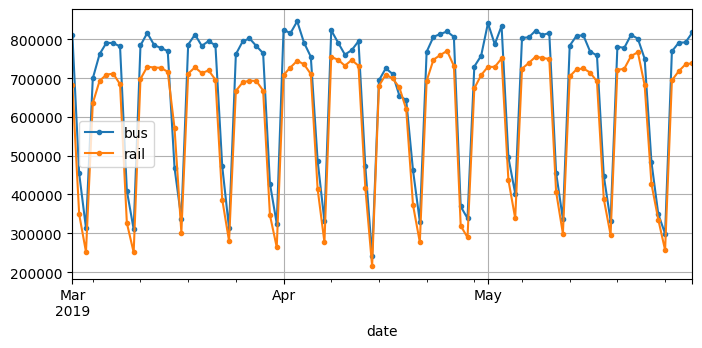

In [5]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5))
plt.show()

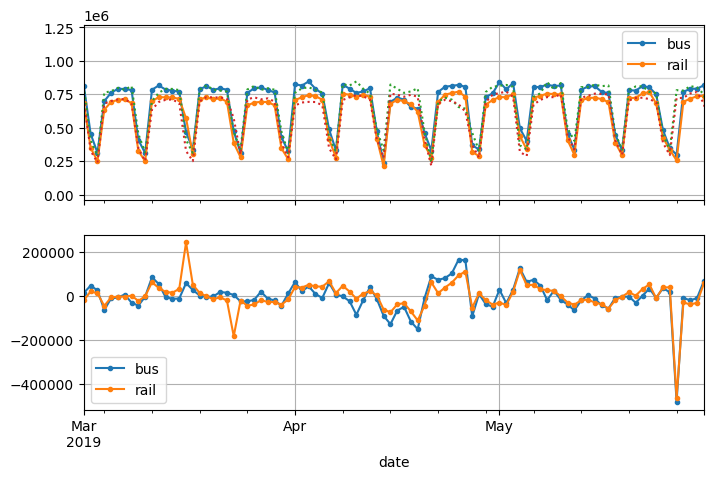

In [6]:
diff_7 = df[["bus","rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2,1,sharex=True, figsize=(8,5))
df.plot(ax=axs[0], grid=True, marker=".")
df.shift(7).plot(ax=axs[0],grid=True,legend=False,linestyle=":")
diff_7.plot(ax = axs[1], grid=True, marker=".")
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

# Model 1: Naive approach

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus","rail"]]["2019-03":"2019-05"]

In [10]:
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [11]:
period = slice("2001","2019")

<ipython-input-12-4ad19a42165d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample("M").mean()


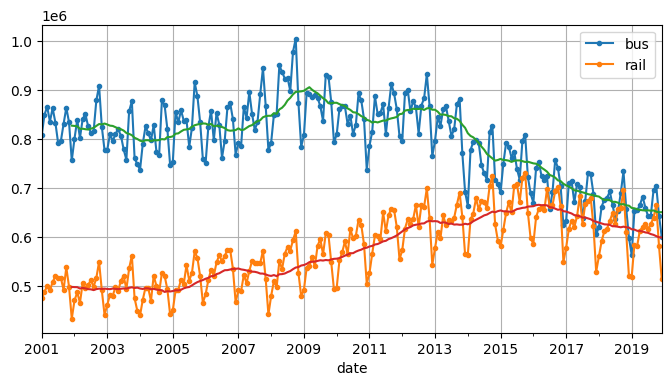

In [12]:
df_monthly = df.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker = ".")
rolling_average_12_months.plot(ax = ax, grid=True, legend=False)
plt.show()

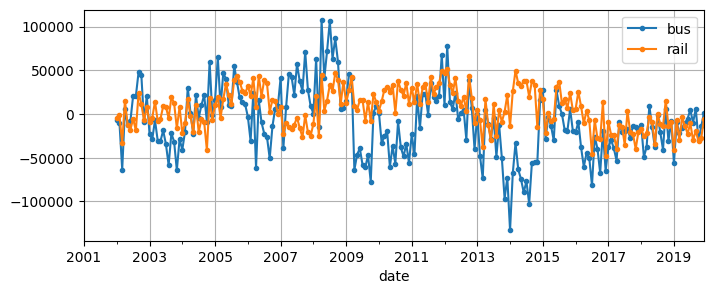

In [13]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

In [14]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid= df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-05":] / 1e6

# Data loading with Keras

In [15]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed = 42
)

In [16]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Model 2: Regression

In [17]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience = 30, restore_best_weights=True
)

In [19]:
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [20]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=["mae"])

In [21]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=100,
                    callbacks=[early_stopping_cb])

Epoch 1/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0885 - mae: 0.3294 - val_loss: 0.0158 - val_mae: 0.1317
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0196 - mae: 0.1498 - val_loss: 0.0132 - val_mae: 0.1249
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0126 - mae: 0.1175 - val_loss: 0.0084 - val_mae: 0.0956
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0107 - mae: 0.1084 - val_loss: 0.0076 - val_mae: 0.0926
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0099 - mae: 0.1042 - val_loss: 0.0070 - val_mae: 0.0873
Epoch 6/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0074 - mae: 0.0873 - val_loss: 0.0061 - val_mae: 0.0804
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0065 - mae: 0.0813 - val_loss: 0.0053 - val_mae: 0.0730
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0062

In [22]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae*1e6

3/3 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0389


38884.542882442474

# Model 3: Simple RNN

In [23]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [24]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs = 100):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience = 30, restore_best_weights=True)
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=["mae"])
  history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs,
                    callbacks=[early_stopping_cb])
  valid_loss, valid_mae = model.evaluate(valid_set)
  return valid_mae * 1e6

In [25]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate = 0.05)

Epoch 1/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0410 - mae: 0.2248 - val_loss: 0.0139 - val_mae: 0.1566
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0145 - mae: 0.1385 - val_loss: 0.0077 - val_mae: 0.1079
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0081 - mae: 0.1003 - val_loss: 0.0035 - val_mae: 0.0686
Epoch 4/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0053 - mae: 0.0766 - val_loss: 0.0031 - val_mae: 0.0626
Epoch 5/100
33/33 [==============================] - 1s 14ms/step - loss: 0.0043 - mae: 0.0677 - val_loss: 0.0029 - val_mae: 0.0583
Epoch 6/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0040 - mae: 0.0635 - val_loss: 0.0029 - val_mae: 0.0570
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0036 - mae: 0.0606 - val_loss: 0.0031 - val_mae: 0.0586
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0

28556.261211633682

# Model 4: Deep RNNs

In [26]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True,
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(1)
])

In [27]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/100
33/33 [==============================] - 3s 32ms/step - loss: 0.0326 - mae: 0.1968 - val_loss: 0.0175 - val_mae: 0.1589
Epoch 2/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0192 - mae: 0.1666 - val_loss: 0.0266 - val_mae: 0.1495
Epoch 3/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0182 - mae: 0.1621 - val_loss: 0.0162 - val_mae: 0.1593
Epoch 4/100
33/33 [==============================] - 1s 32ms/step - loss: 0.0171 - mae: 0.1611 - val_loss: 0.0162 - val_mae: 0.1458
Epoch 5/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0174 - mae: 0.1625 - val_loss: 0.0163 - val_mae: 0.1423
Epoch 6/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0174 - mae: 0.1612 - val_loss: 0.0186 - val_mae: 0.1273
Epoch 7/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0177 - mae: 0.1639 - val_loss: 0.0163 - val_mae: 0.1415
Epoch 8/100
33/33 [==============================] - 1s 27ms/step - loss: 0.

123367.22016334534

# Model Prediction

In [28]:
import numpy as np

In [29]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
X.shape

(1, 56, 1)

In [30]:
for step_ahead in range(14):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1,1,1)], axis=1)

1/1 [==============================] - 0s 17ms/step


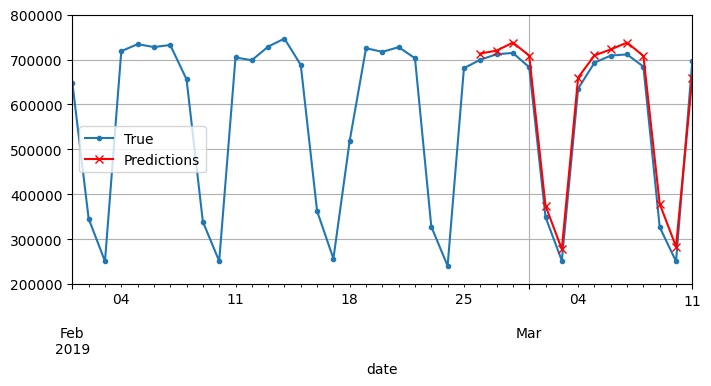

In [31]:
Y_pred = pd.Series(X[0,-14:,0],
                   index=pd.date_range("2019-02-26","2019-03-11"))

fig, ax = plt.subplots(figsize=(8,3.5))
(rail_valid*1e6)["2019-02-01":"2019-03-11"].plot(label=True, marker=".",
                                                 ax=ax)
(Y_pred*1e6).plot(label="Predictions", grid=True, marker="x", color="r",
                  ax = ax)
ax.set_ylim([200_000, 800_000])
plt.legend()
plt.show()

Model 5: LSTM

In [32]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

In [33]:
fit_and_evaluate(lstm_model, train_ds, valid_ds, learning_rate=0.01, epochs=20)

Epoch 1/20
33/33 [==============================] - 2s 29ms/step - loss: 0.0718 - mae: 0.2916 - val_loss: 0.0188 - val_mae: 0.1828
Epoch 2/20
33/33 [==============================] - 1s 22ms/step - loss: 0.0185 - mae: 0.1661 - val_loss: 0.0175 - val_mae: 0.1410
Epoch 3/20
33/33 [==============================] - 1s 24ms/step - loss: 0.0178 - mae: 0.1639 - val_loss: 0.0176 - val_mae: 0.1386
Epoch 4/20
33/33 [==============================] - 1s 25ms/step - loss: 0.0179 - mae: 0.1631 - val_loss: 0.0174 - val_mae: 0.1390
Epoch 5/20
33/33 [==============================] - 1s 21ms/step - loss: 0.0175 - mae: 0.1608 - val_loss: 0.0166 - val_mae: 0.1472
Epoch 6/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0173 - mae: 0.1627 - val_loss: 0.0169 - val_mae: 0.1422
Epoch 7/20
33/33 [==============================] - 1s 21ms/step - loss: 0.0174 - mae: 0.1625 - val_loss: 0.0170 - val_mae: 0.1395
Epoch 8/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0172 - m

143364.90631103516

# Model :6 GRU

In [34]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

In [35]:
fit_and_evaluate(gru_model, train_ds, valid_ds, learning_rate=0.01, epochs=20)

Epoch 1/20
33/33 [==============================] - 3s 31ms/step - loss: 0.0577 - mae: 0.2729 - val_loss: 0.0182 - val_mae: 0.1813
Epoch 2/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0178 - mae: 0.1599 - val_loss: 0.0166 - val_mae: 0.1482
Epoch 3/20
33/33 [==============================] - 1s 21ms/step - loss: 0.0174 - mae: 0.1630 - val_loss: 0.0169 - val_mae: 0.1422
Epoch 4/20
33/33 [==============================] - 1s 28ms/step - loss: 0.0174 - mae: 0.1603 - val_loss: 0.0168 - val_mae: 0.1421
Epoch 5/20
33/33 [==============================] - 1s 21ms/step - loss: 0.0173 - mae: 0.1631 - val_loss: 0.0169 - val_mae: 0.1404
Epoch 6/20
33/33 [==============================] - 1s 22ms/step - loss: 0.0173 - mae: 0.1615 - val_loss: 0.0168 - val_mae: 0.1418
Epoch 7/20
33/33 [==============================] - 1s 22ms/step - loss: 0.0172 - mae: 0.1618 - val_loss: 0.0166 - val_mae: 0.1429
Epoch 8/20
33/33 [==============================] - 1s 22ms/step - loss: 0.0173 - m

139850.79526901245

## Resources

- [Hands-on ML with Scikit-Learn & TensorFlow](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb)

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎
